In [357]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans,DBSCAN
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy.spatial.distance import cdist
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import chi2
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
import collections
import time
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')
# plt.style.use('ggplot')  # 更改绘图风格 R语言绘图库的风格
plt.rcParams['font.family']='Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False

## 数据来源
https://www.kaggle.com/datasets/mrsohelrana/bank-marketing-data  
数据时间:从2008年5月到2010年11月

## 目的:
预测用户是否会订阅定期定期存款

# 数据预处理

In [282]:
df = pd.read_csv('bank-additional-full.csv',';')
df_train = pd.read_csv('bank-additional.csv',';')

In [283]:
# 列名更改成中文
df.columns = ["年龄", "职业", "婚姻状况", "受教育程度", "信用是否违约", "是否有房屋贷款", 
              "是否有个人贷款", "联系方式", "最后通话的月份", "最后通话是星期几",
              "最后通话时长", "本次营销期间接触客户的次数", "客户上次营销后经过的天数",
              "客户在本次营销前与银行接触的次数", "上次营销的结果", "就业变化率（季度指标）", 
              "消费者物价指数（月度指标）", "消费者信心指数（月度指标）", "欧元区3个月利率（日度指标）", 
              "就业人数（季度指标）", "订阅结果"]


In [284]:
df.head()

df['最后通话时长'] = df['最后通话时长']/60
df['最后通话时长']

0        4.350000
1        2.483333
2        3.766667
3        2.516667
4        5.116667
           ...   
41183    5.566667
41184    6.383333
41185    3.150000
41186    7.366667
41187    3.983333
Name: 最后通话时长, Length: 41188, dtype: float64

In [285]:
# 查看各列的值,数据类型,
for i in df.columns:
    print('-'*20+i+'-'*20)
    print('type:',type(df[i]))
    print('label_cnt:',df[i].nunique())
    print('\n')
    print('label:')
    print(df[i].value_counts().sort_index())
    print('\n')

--------------------年龄--------------------
type: <class 'pandas.core.series.Series'>
label_cnt: 78


label:
17      5
18     28
19     42
20     65
21    102
     ... 
91      2
92      4
94      1
95      1
98      2
Name: 年龄, Length: 78, dtype: int64


--------------------职业--------------------
type: <class 'pandas.core.series.Series'>
label_cnt: 12


label:
admin.           10422
blue-collar       9254
entrepreneur      1456
housemaid         1060
management        2924
retired           1720
self-employed     1421
services          3969
student            875
technician        6743
unemployed        1014
unknown            330
Name: 职业, dtype: int64


--------------------婚姻状况--------------------
type: <class 'pandas.core.series.Series'>
label_cnt: 4


label:
divorced     4612
married     24928
single      11568
unknown        80
Name: 婚姻状况, dtype: int64


--------------------受教育程度--------------------
type: <class 'pandas.core.series.Series'>
label_cnt: 8


label:
basic.4y          

In [286]:
# 查看类型
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   年龄                41188 non-null  int64  
 1   职业                41188 non-null  object 
 2   婚姻状况              41188 non-null  object 
 3   受教育程度             41188 non-null  object 
 4   信用是否违约            41188 non-null  object 
 5   是否有房屋贷款           41188 non-null  object 
 6   是否有个人贷款           41188 non-null  object 
 7   联系方式              41188 non-null  object 
 8   最后通话的月份           41188 non-null  object 
 9   最后通话是星期几          41188 non-null  object 
 10  最后通话时长            41188 non-null  float64
 11  本次营销期间接触客户的次数     41188 non-null  int64  
 12  客户上次营销后经过的天数      41188 non-null  int64  
 13  客户在本次营销前与银行接触的次数  41188 non-null  int64  
 14  上次营销的结果           41188 non-null  object 
 15  就业变化率（季度指标）       41188 non-null  float64
 16  消费者物价指数（月度指标）     41188 non-null  float6

In [287]:
# 替换预测结果为数字标签
df['订阅结果'].replace({'no':0,'yes':1},inplace=True) 

In [288]:
df.describe([0.1,0.25,0.5,0.75,0.9]).astype('int')
# 注:数据中的999表示从未沟通

,年龄,最后通话时长,本次营销期间接触客户的次数,客户上次营销后经过的天数,客户在本次营销前与银行接触的次数,就业变化率（季度指标）,消费者物价指数（月度指标）,消费者信心指数（月度指标）,欧元区3个月利率（日度指标）,就业人数（季度指标）,订阅结果
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
mean,40,4,2,962,0,0,93,-40,3,5167,0
std,10,4,2,186,0,1,0,4,1,72,0
min,17,0,1,0,0,-3,92,-50,0,4963,0
10%,28,0,1,999,0,-1,92,-46,1,5076,0
25%,32,1,1,999,0,-1,93,-42,1,5099,0
50%,38,3,2,999,0,1,93,-41,4,5191,0
75%,47,5,3,999,0,1,93,-36,4,5228,0
90%,55,9,5,999,1,1,94,-36,4,5228,1
max,98,81,56,999,7,1,94,-26,5,5228,1


## 小结
1.数据不存在缺失和异常值.不需要做处理.
2.通过观察数据可知,当前订阅的人数较少.

<AxesSubplot:>

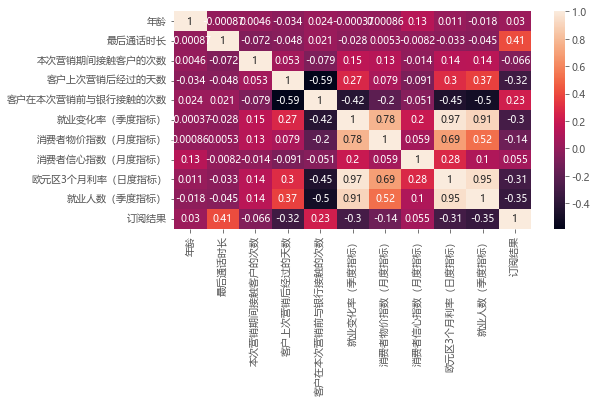

In [289]:
plt.figure(figsize=(8,4))
sns.heatmap(df.corr(),annot=True)

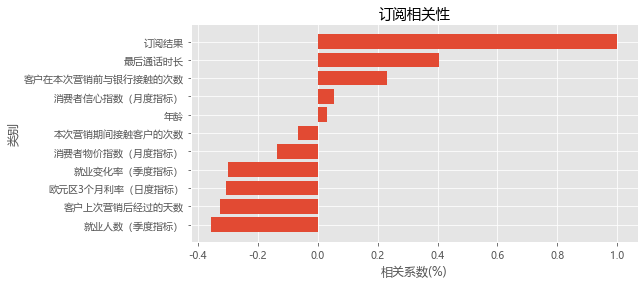

In [290]:
plt.figure(figsize=(8,4))
corr = df.corr()['订阅结果'].sort_values()
plt.title('订阅相关性')
plt.ylabel('类别')
plt.xlabel('相关系数(%)')
plt.barh(corr.index, corr.values)
plt.show()

如图,客户是否订阅和最后通话时长,营销前接触次数,消费者信心指数三个指标呈较高的正相关(大于20%).和消费者物价指数,就业变化率,欧元区汇率,
上次营销后经过天数,就业人数呈较高的负相关性.

In [291]:
# 非数字标签与订阅的相关性分布
df.columns


Index(['年龄', '职业', '婚姻状况', '受教育程度', '信用是否违约', '是否有房屋贷款', '是否有个人贷款', '联系方式',
       '最后通话的月份', '最后通话是星期几', '最后通话时长', '本次营销期间接触客户的次数', '客户上次营销后经过的天数',
       '客户在本次营销前与银行接触的次数', '上次营销的结果', '就业变化率（季度指标）', '消费者物价指数（月度指标）',
       '消费者信心指数（月度指标）', '欧元区3个月利率（日度指标）', '就业人数（季度指标）', '订阅结果'],
      dtype='object')

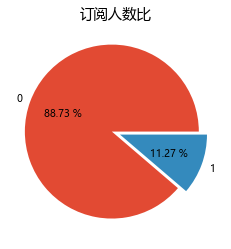

In [292]:
total = df.groupby(['订阅结果'])['年龄'].count().reset_index()

plt.pie(total.年龄, explode=[0.05, 0.05], autopct='%.2f %%', labels=total.订阅结果.tolist())
plt.title('订阅人数比')
plt.show()

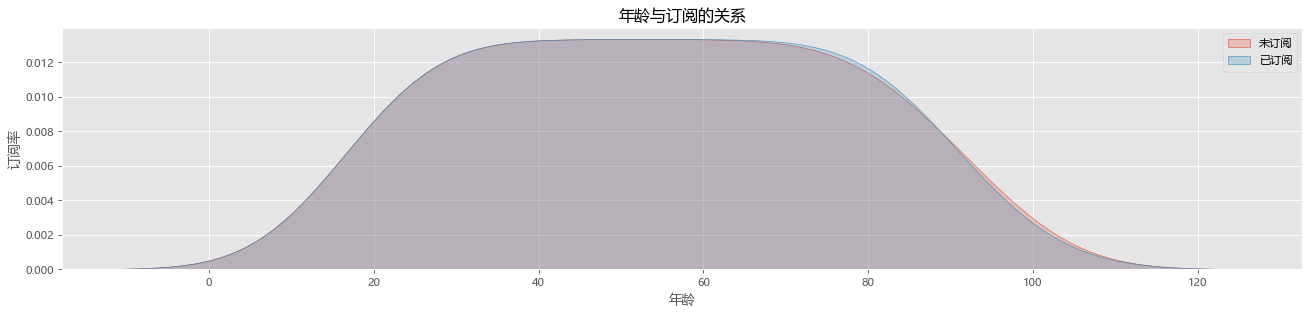

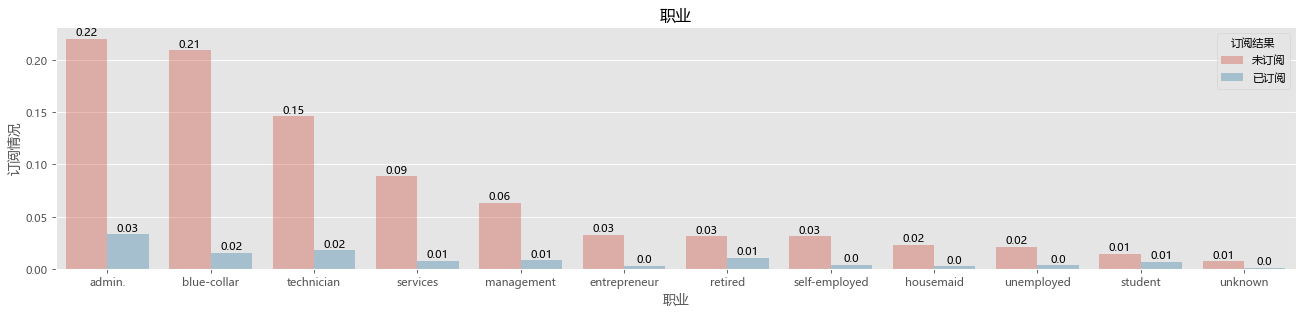

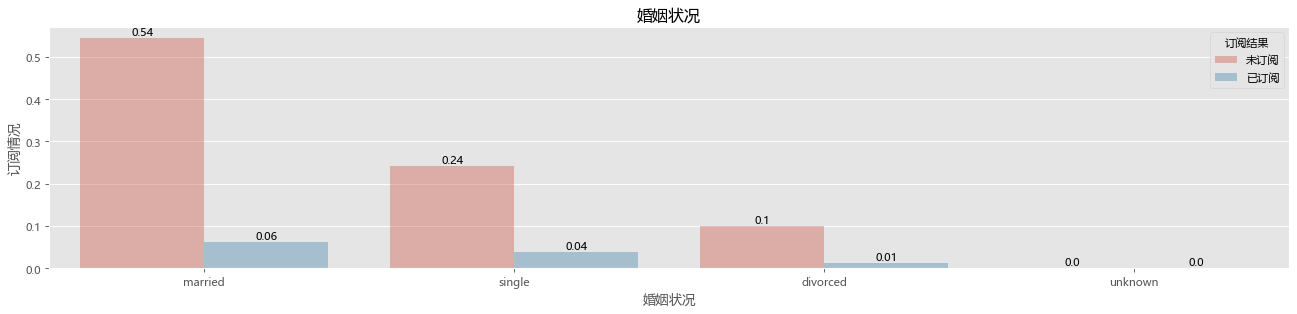

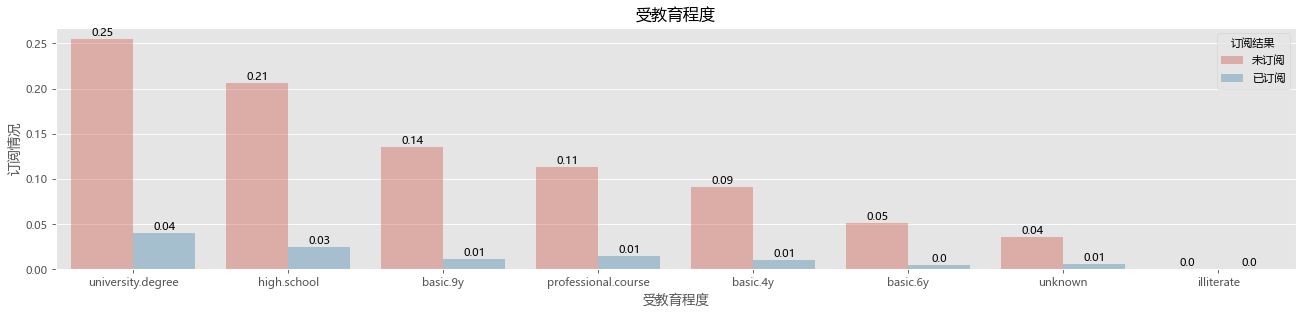

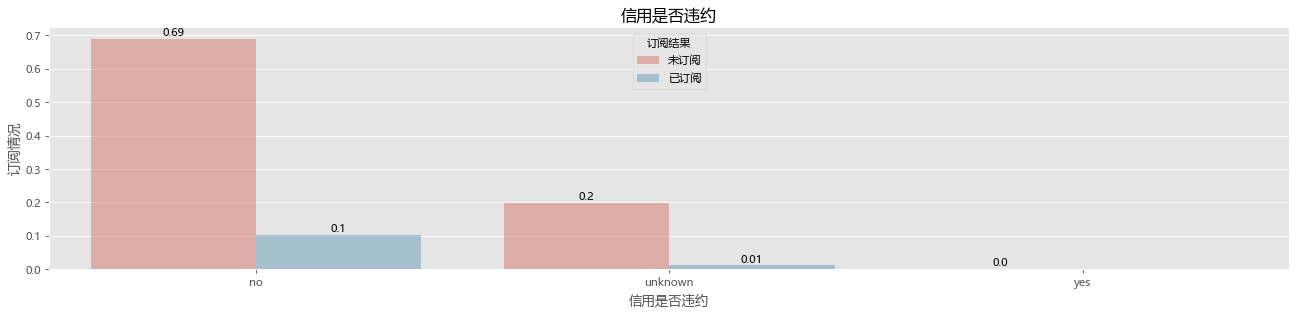

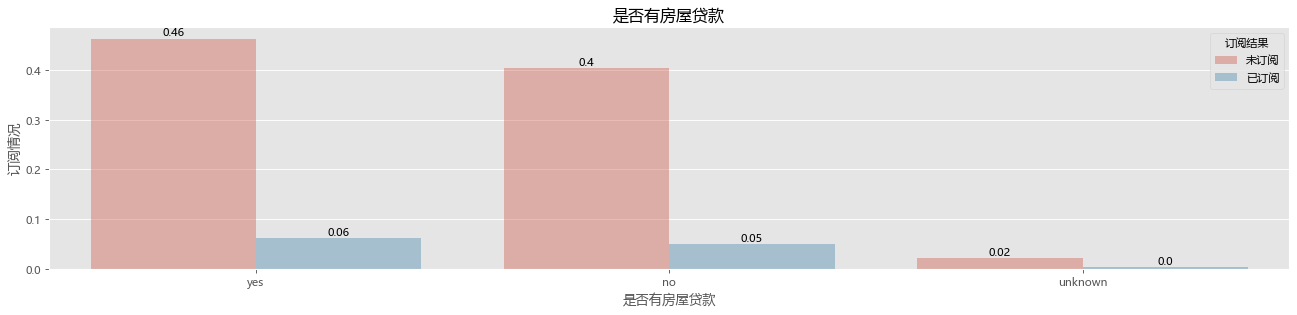

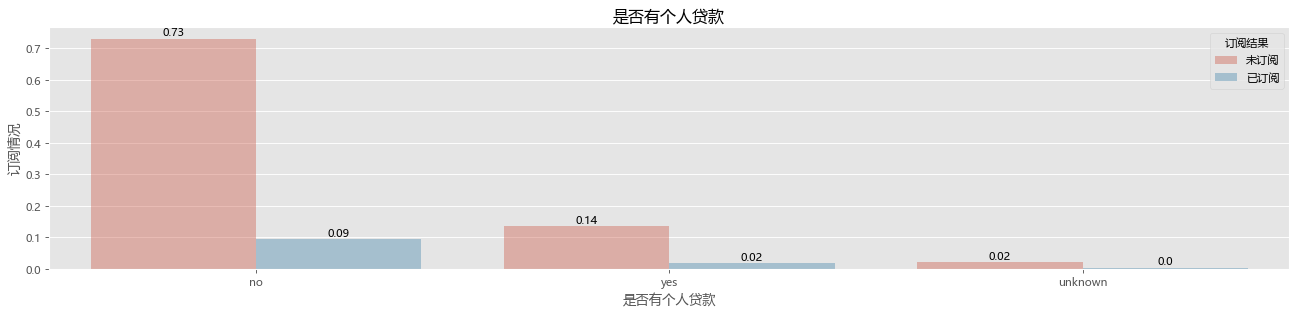

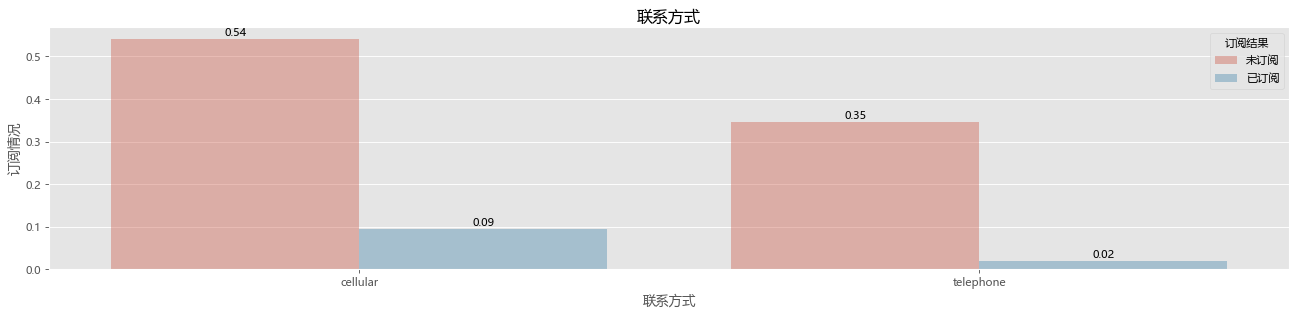

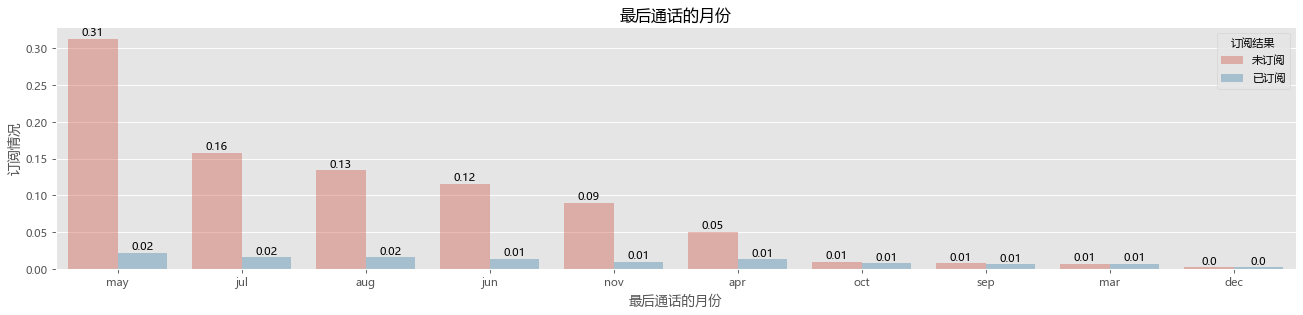

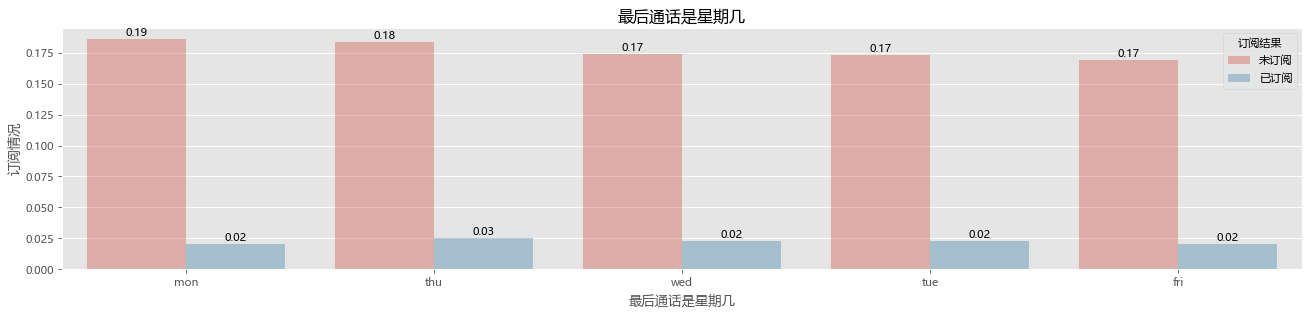

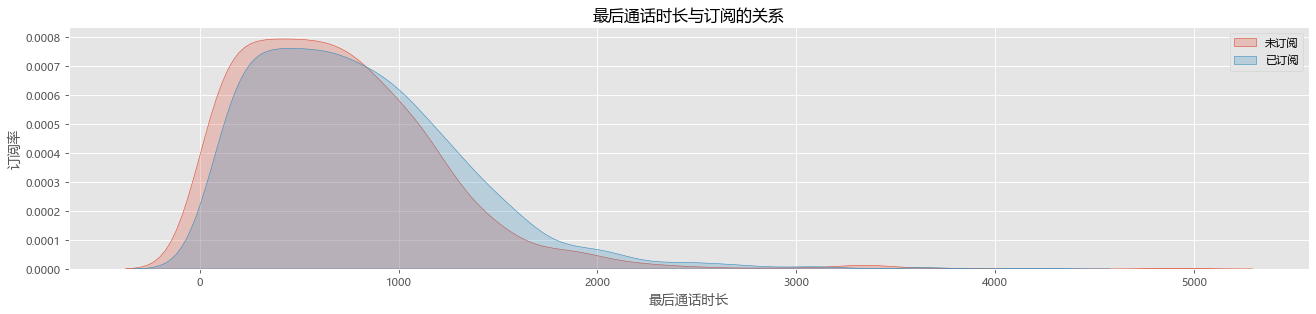

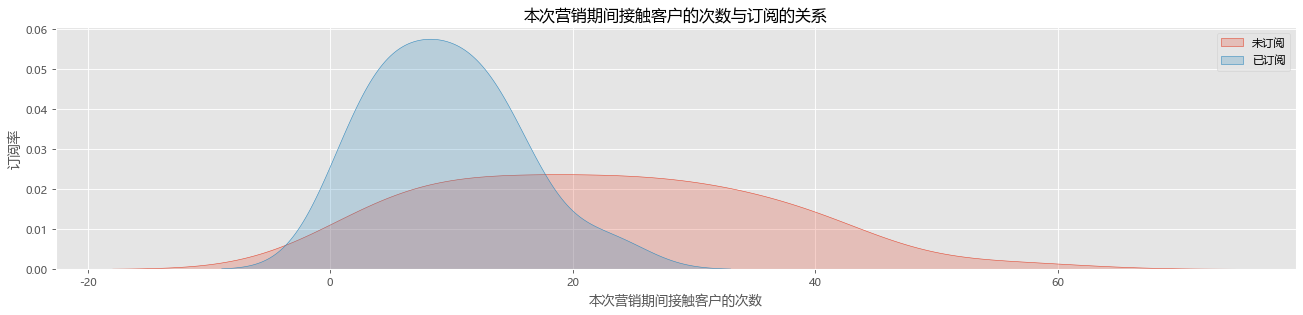

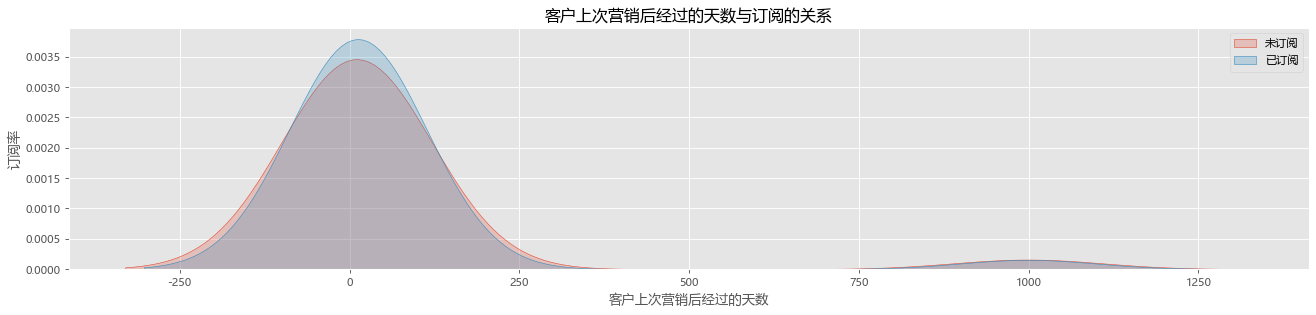

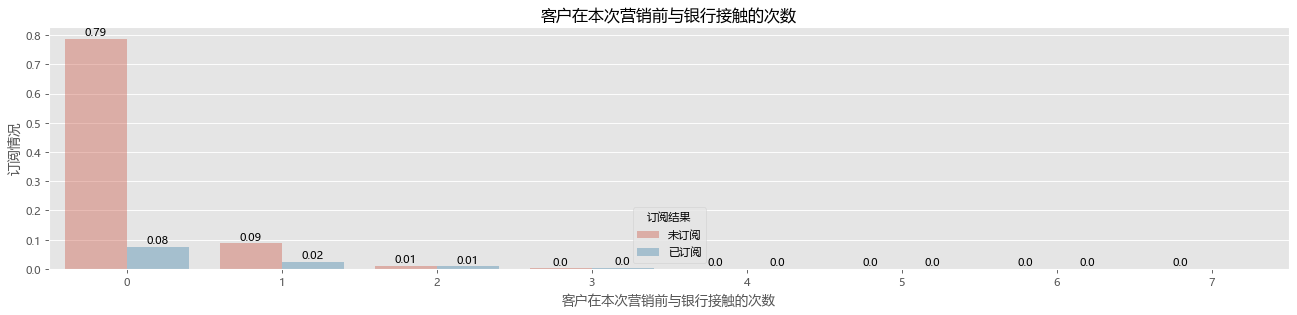

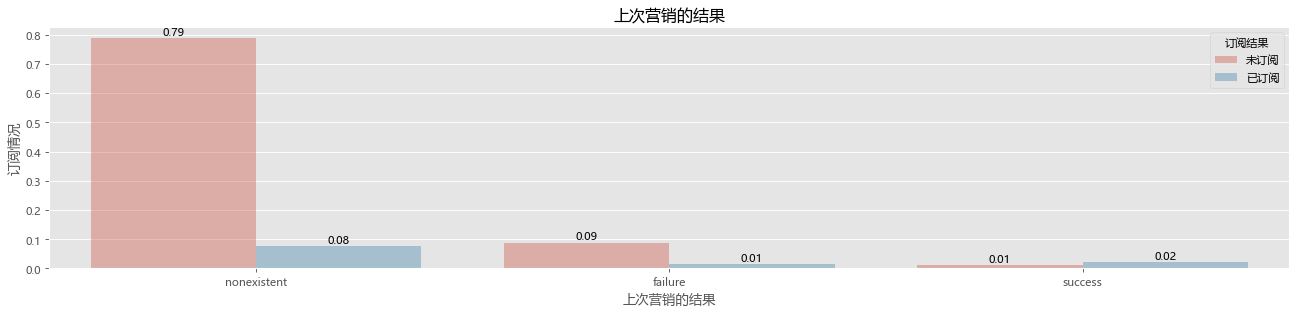

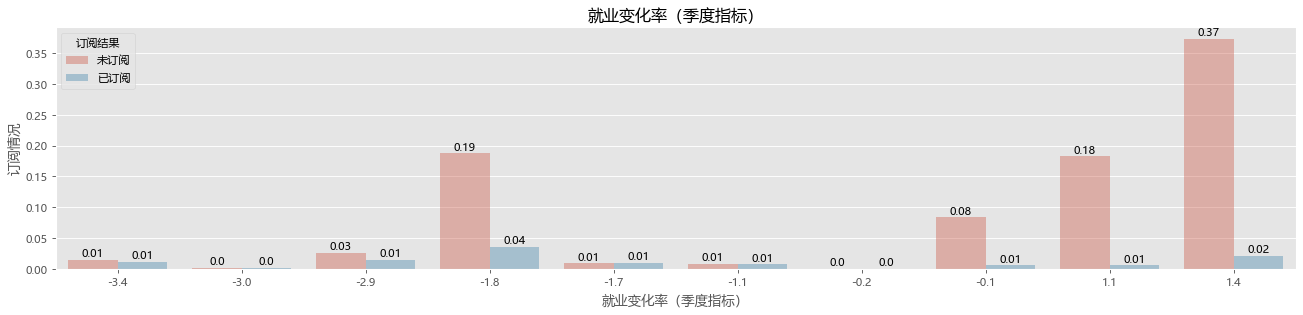

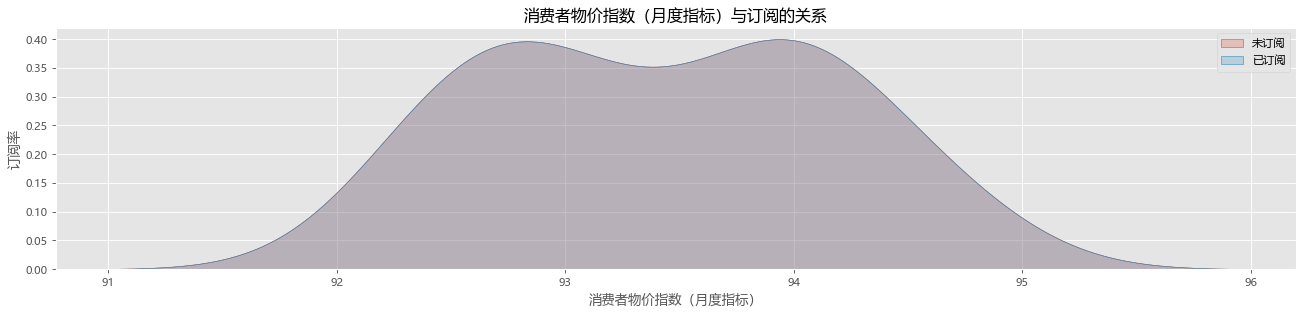

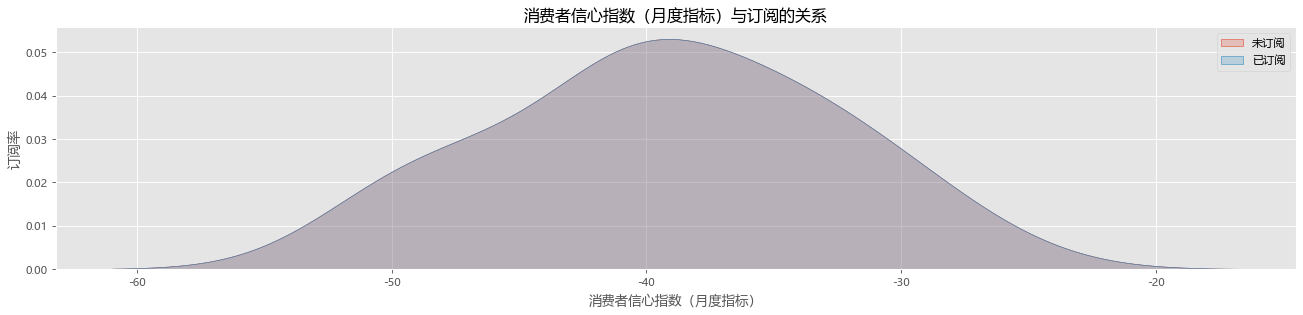

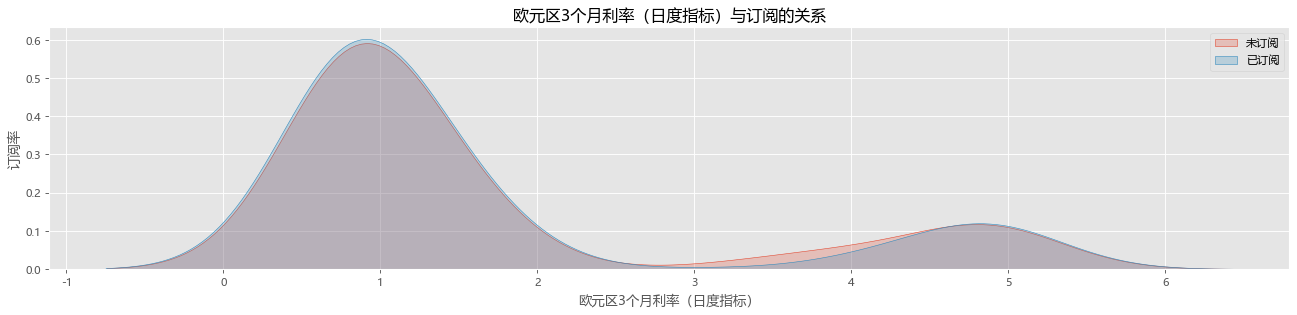

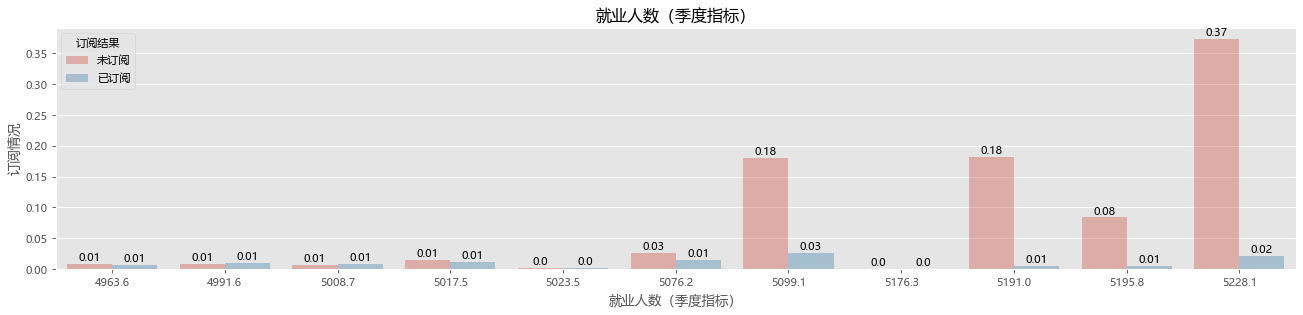

In [14]:
lis = ["年龄", "职业", "婚姻状况", "受教育程度", "信用是否违约", "是否有房屋贷款", 
              "是否有个人贷款", "联系方式", "最后通话的月份", "最后通话是星期几",
              "最后通话时长", "本次营销期间接触客户的次数", "客户上次营销后经过的天数",
              "客户在本次营销前与银行接触的次数", "上次营销的结果", "就业变化率（季度指标）", 
              "消费者物价指数（月度指标）", "消费者信心指数（月度指标）", "欧元区3个月利率（日度指标）", 
              "就业人数（季度指标）"]

def plt_img(i):
    temp = (df.groupby([i])['订阅结果'].value_counts() / len(df[i])).sort_values(ascending=False).to_frame()

    
    temp.rename(columns={"订阅结果":'订阅情况'},inplace=True)
    temp.reset_index(inplace=True)
    fig,ax = plt.subplots(figsize=(20,4),dpi=80)
    
    if df[i].nunique() <= 20: # 数量大于20,说明非数字标签,画密度图

        temp['订阅结果'].replace({1:'已订阅',0:'未订阅'},inplace =True)
        sns.barplot(ax=ax,x=i,y='订阅情况', hue='订阅结果', data=temp,alpha=0.4)
        for p in ax.containers:
            ax.bar_label(p, label_type='edge', labels=p.datavalues.astype(float).round(2))
        
        ax.set_title(i)
        plt.show()
    else:
        sns.kdeplot(temp[temp['订阅结果']==0][i].dropna(), ax=ax, label='未订阅',shade = True)
        sns.kdeplot(temp[temp['订阅结果']==1][i].dropna(), ax=ax, label='已订阅',shade = True)
        ax.set_xlabel(i)
        ax.set_ylabel('订阅率')
        ax.set_title(f'{i}与订阅的关系')
        ax.legend()
 
        
for i in lis:
    plt_img(i)

# 小结 
各个字段与是否订阅的相关性解释.以下分析主要通过同一标签内未订阅和订阅人数的比例进行评估.  

1.职业,从图表看,大部分职业的订阅与未订阅人数比约为1:6左右.而退休人员,学生的比例较高,这两者的共同点是经济来源比较单一.日常生活中可能也没有太多需要动用大笔资金的场景.定期存款可以给他们一定的收入. 
    
2.受教育程度,高中和大学学历的人更倾向于订阅,学历越高,人数比例越大.  

3.有贷款的用户比无贷款的人员订阅占比更高.  

4.沟通情况:
(1)通话时间越长,用户越容易订阅  
(2)事前有过沟通,沟通次数在2次的用户更容易订阅.  
(3)距离上次沟通时间越短的用户越容易订阅  
(4)通过移动电话进行沟通的效果比固话的沟通方式更好.  
(5)之前沟通成功的用户订阅比例较大.但需要注意的是营销成功的用户中也有1/3的用户本次不订阅

5.就业人数较低,就业形势比较差时订阅定期存款的人数相对较多.

总结:
(1)可以看出之前未营销的人数占比较大.已营销的用户占比13%.其中2%用户成功.占比约15.3%.如果扩大营销比例,每扩大10%,可能就会新增1.53%的订阅用户  
(2)降低固话的沟通方式,提高移动电话的沟通比例.  
(3)高学历.学生或退休人员,有贷款的用户,在就业形势比较差的时候可以加入营销力度.  

In [293]:
df.columns

Index(['年龄', '职业', '婚姻状况', '受教育程度', '信用是否违约', '是否有房屋贷款', '是否有个人贷款', '联系方式',
       '最后通话的月份', '最后通话是星期几', '最后通话时长', '本次营销期间接触客户的次数', '客户上次营销后经过的天数',
       '客户在本次营销前与银行接触的次数', '上次营销的结果', '就业变化率（季度指标）', '消费者物价指数（月度指标）',
       '消费者信心指数（月度指标）', '欧元区3个月利率（日度指标）', '就业人数（季度指标）', '订阅结果'],
      dtype='object')

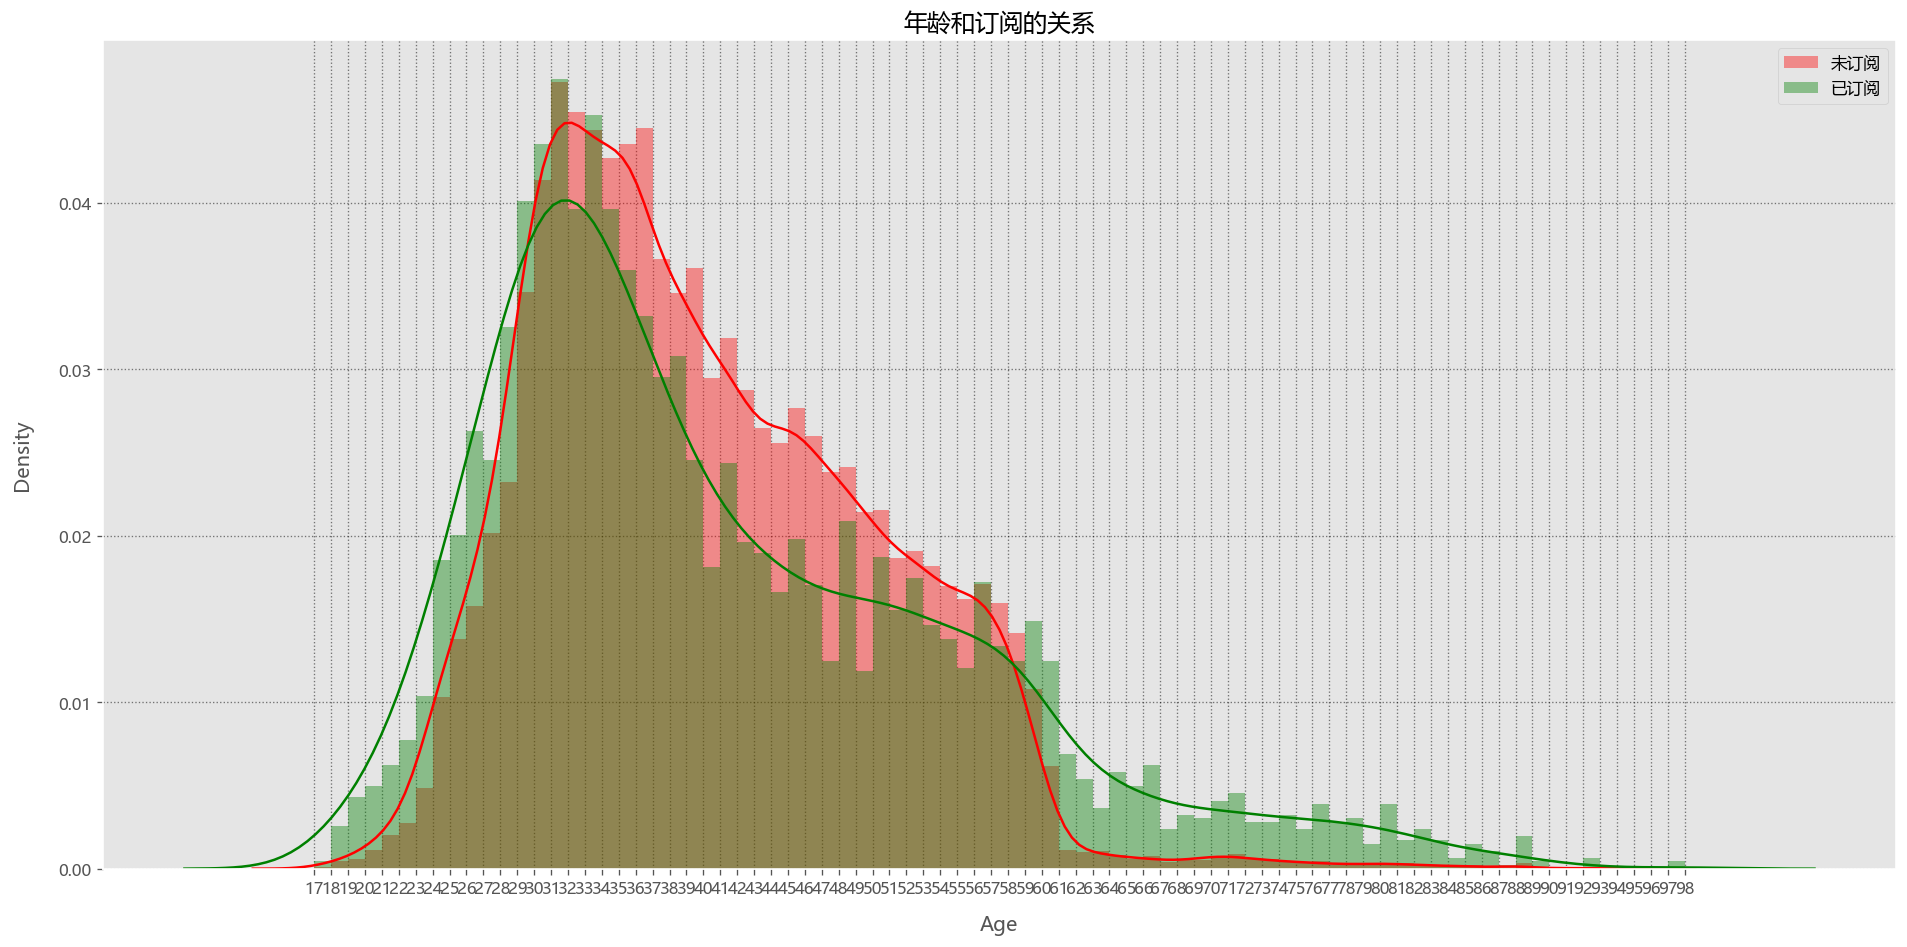

In [302]:

plt.figure(figsize=(16,8),dpi=120)
plt.title('年龄和订阅的关系')
sns.distplot(df['年龄'][df[ '订阅结果'] ==  0], bins=np.arange(df['年龄'].min(), df['年龄'].max() + 1), color='r', label='未订阅')
sns.distplot(df['年龄'][df[ '订阅结果']  == 1], bins=np.arange(df['年龄'].min(), df['年龄'].max() + 1), color='green', label='已订阅')

plt.legend()
plt.xticks(np.arange(df['年龄'].min(), df['年龄'].max() + 1))
plt.xlabel('Age', fontsize=12, labelpad=10)
plt.ylabel('Density', labelpad=15)


plt.grid(linestyle=':', color='black', alpha=0.5)

plt.tight_layout()
plt.show()

In [312]:
def class_age(x):
    if x >= 17 and x <= 31:
        return '推荐'
    if x >= 59:
        return 'Rekomendation'
    if x >= 32 and x <= 58:
        return 'Unrecomendation'

In [313]:
df['年龄分组'] = df.apply(lambda x:class_age(x['年龄']),axis=1)

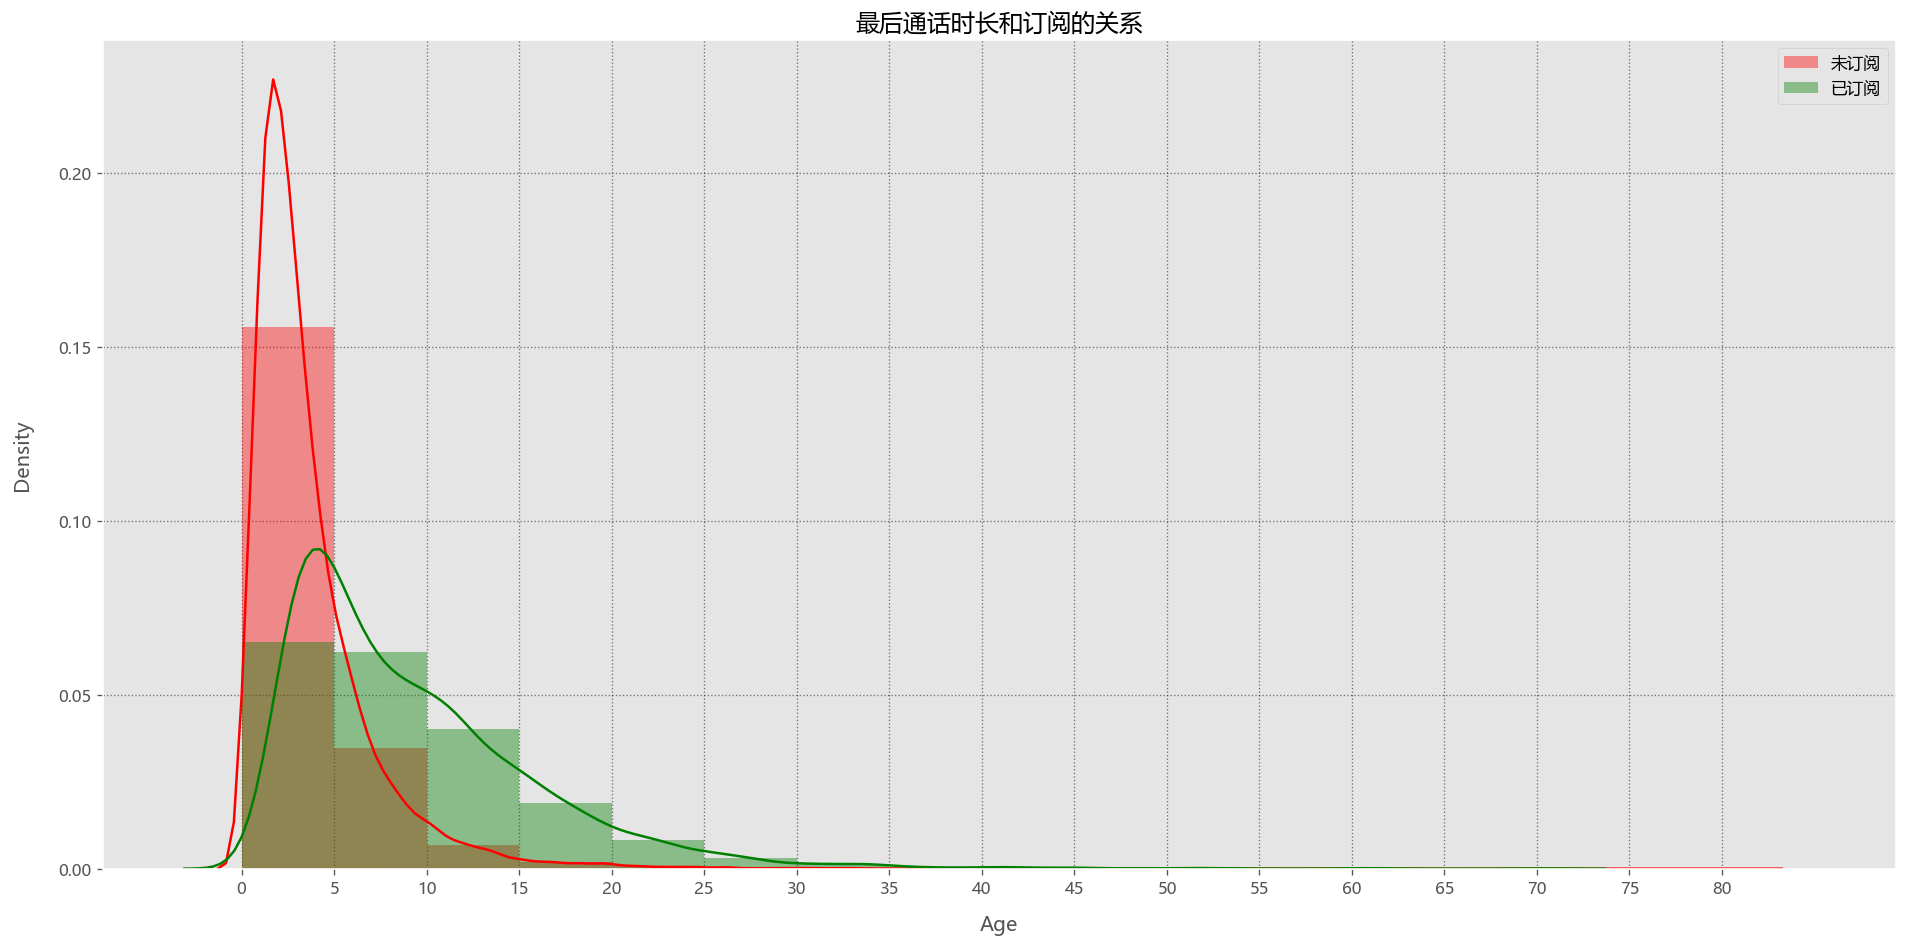

In [314]:
plt.figure(figsize=(16,8),dpi=120)
plt.title('最后通话时长和订阅的关系')
sns.distplot(df['最后通话时长'][df[ '订阅结果'] ==  0], bins=np.arange(0,90,5), color='r', label='未订阅')
sns.distplot(df['最后通话时长'][df[ '订阅结果']  == 1], bins=np.arange(0,90,5), color='green', label='已订阅')

plt.legend()
plt.xticks(np.arange(0,df['最后通话时长'].max() ,5))
plt.xlabel('Age', fontsize=12, labelpad=10)
plt.ylabel('Density', labelpad=15)


plt.grid(linestyle=':', color='black', alpha=0.5)

plt.tight_layout()
plt.show()

In [316]:
# 划分
def duration_status(x):
    if x < 5:
        return 0
    elif x >= 5 and x <= 15:
        return 1
    else:
        return 2
    
df['通话时长分组'] = df['最后通话时长'].apply(lambda x: duration_status(x))

In [318]:
# 卡方检验
df_chi = df.loc[:,['年龄分组', '职业', '婚姻状况', '受教育程度', '信用是否违约', '是否有房屋贷款', '是否有个人贷款', '联系方式',
       '最后通话的月份', '最后通话是星期几', '通话时长分组', '本次营销期间接触客户的次数', '客户上次营销后经过的天数',
       '客户在本次营销前与银行接触的次数', '上次营销的结果', '就业变化率（季度指标）', '消费者物价指数（月度指标）',
       '消费者信心指数（月度指标）', '欧元区3个月利率（日度指标）', '就业人数（季度指标）', '订阅结果']]

In [319]:
LE = LabelEncoder()
OH = OneHotEncoder(categories='auto', sparse=False)
scaler = StandardScaler()
for i in df_chi.columns:
    df_chi[i] = LE.fit_transform(df_chi[i])

In [320]:
x = df_chi.drop(columns = '订阅结果')
y = df_chi['订阅结果']

chi_scores = chi2(x,y)

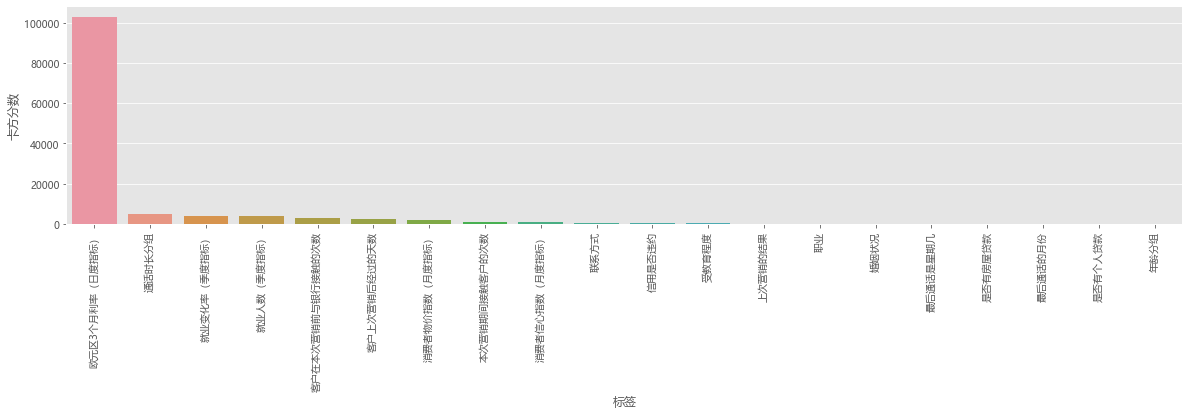

In [321]:
# 卡方得分
chi_df = pd.DataFrame({'标签':x.columns.to_list(),'卡方分数':chi_scores[0]})
chi_df.sort_values('卡方分数', ascending=False, inplace=True)
plt.figure(figsize=(20,4))
sns.barplot(x='标签',y='卡方分数',data=chi_df)
plt.xticks(rotation=90)
plt.show()

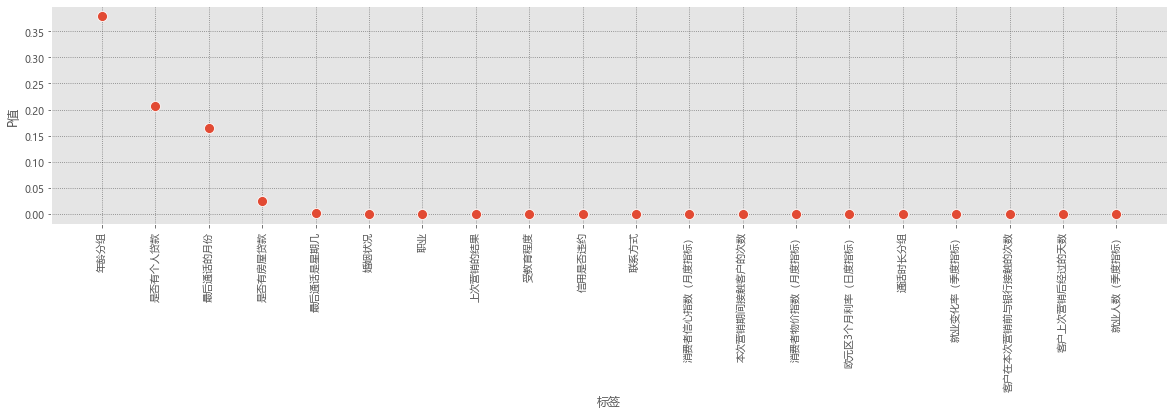

In [325]:
# 卡方得分
chi_df = pd.DataFrame({'标签':x.columns.to_list(),'P值':chi_scores[1]})
chi_df.sort_values('P值', ascending=False, inplace=True)
plt.figure(figsize=(20,4))
sns.scatterplot(x='标签',y='P值',data=chi_df,s=100)
plt.grid(linestyle=':', color='black', alpha=0.5)
plt.xticks(rotation=90)
plt.show()


In [328]:
feature_categorical_rekomended = chi_df[chi_df['P值'] < 0.05].标签.unique().tolist()
feature_categorical_rekomended

['是否有房屋贷款',
 '最后通话是星期几',
 '婚姻状况',
 '职业',
 '上次营销的结果',
 '受教育程度',
 '信用是否违约',
 '联系方式',
 '消费者信心指数（月度指标）',
 '本次营销期间接触客户的次数',
 '消费者物价指数（月度指标）',
 '欧元区3个月利率（日度指标）',
 '通话时长分组',
 '就业变化率（季度指标）',
 '客户在本次营销前与银行接触的次数',
 '客户上次营销后经过的天数',
 '就业人数（季度指标）']

In [429]:
# 选取特征
df_tain = df[feature_categorical_rekomended]

for i in df_tain.columns:

    if df_tain[i].dtype == 'object':
        df_tain.loc[:, i] = LE.fit_transform(df_tain[i])
    else:
        df_tain.loc[:, i] = scaler.fit_transform(df_tain[i].values.reshape(-1, 1))

df_test = df['订阅结果']


x_train1,x_test1 = df_tain[:38000],df_tain[38000:]
y_train1,y_test1 = df_test[:38000],df_test[38000:]

In [417]:
    #采用 StandardScaler 方法对数据规范化：均值为0，方差为1的正态分布
    #采用 StandardScaler 方法对数据规范化：均值为0，方差为1的正态分布
classifiers = [
    SVC(random_state = 1, kernel = 'rbf'),    
    DecisionTreeClassifier(random_state = 1, criterion = 'gini'),
    RandomForestClassifier(random_state = 1, criterion = 'gini',max_depth=55,min_samples_leaf=50,n_estimators = 200),
    KNeighborsClassifier(metric = 'minkowski'),
    AdaBoostClassifier(random_state = 1), 
    #MLPClassifier(random_state = 1)
]
# 分类器名称
classifier_names = [
            'svc', 
            'decisiontreeclassifier',
            'randomforestclassifier',
            'kneighborsclassifier',
            'adaboostclassifier',
           # 'mlpclassifier'
]
# 分类器参数
#注意分类器的参数，字典键的格式，GridSearchCV对调优的参数格式是"分类器名"+"__"+"参数名"
classifier_param_grid = [
            {'svc__C':[0.1], 'svc__gamma':[0.01]},
            {'decisiontreeclassifier__max_depth':[6,9,11]},
            {'randomforestclassifier__n_estimators':range(1,11)} ,
            {'kneighborsclassifier__n_neighbors':[4,6,8]},
            {'adaboostclassifier__n_estimators':[70,80,90]},
            #{'mlpclassifier__hidden_layer_sizes':[(100,50),(80,40),(90,),(50,20)]}
]

In [418]:
def GridSearchCV_work(pipeline, train_x, train_y, test_x, test_y, param_grid, score = 'accuracy_score'):
    response = {}
    gridsearch = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv=3, scoring = score)
    # 寻找最优的参数 和最优的准确率分数
    search = gridsearch.fit(train_x, train_y)
    print("GridSearch 最优参数：", search.best_params_)
    print("GridSearch 最优分数： %0.4lf" %search.best_score_)
    #采用predict函数（特征是测试数据集）来预测标识，预测使用的参数是上一步得到的最优参数
    predict_y = gridsearch.predict(test_x)
    print(" 准确率 %0.4lf" %accuracy_score(test_y, predict_y))
    response['predict_y'] = predict_y
    response['accuracy_score'] = accuracy_score(test_y,predict_y)
    return response
 
for model, model_name, model_param_grid in zip(classifiers, classifier_names, classifier_param_grid):
    #采用 StandardScaler 方法对数据规范化：均值为0，方差为1的正态分布
    pipeline = Pipeline([
            (model_name, model)
    ])
    model = GridSearchCV_work(pipeline, x_train, y_train, x_test, y_test, model_param_grid , score = 'accuracy')


GridSearch 最优参数： {'svc__C': 0.1, 'svc__gamma': 0.01}
GridSearch 最优分数： 0.7178
 准确率 0.5056
GridSearch 最优参数： {'decisiontreeclassifier__max_depth': 6}
GridSearch 最优分数： 0.4802
 准确率 0.6593
GridSearch 最优参数： {'randomforestclassifier__n_estimators': 5}
GridSearch 最优分数： 0.3780
 准确率 0.5480
GridSearch 最优参数： {'kneighborsclassifier__n_neighbors': 8}
GridSearch 最优分数： 0.6885
 准确率 0.5988
GridSearch 最优参数： {'adaboostclassifier__n_estimators': 70}
GridSearch 最优分数： 0.4528
 准确率 0.6647


In [419]:
model =  AdaBoostClassifier(n_estimators=70)
model.fit(x_train,y_train)

AdaBoostClassifier(n_estimators=70)

In [420]:
# 评估模型效果
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

cr_train = classification_report(y_train, train_pred)
cr_test = classification_report(y_test, test_pred)

cm_train = confusion_matrix(y_train, train_pred)
cm_test = confusion_matrix(y_test, test_pred)

In [421]:
print('1. 训练分类报告 : \n')
print(cr_train)
print('\n\n2. 测试分类报告 : \n')
print(cr_test)
# 模型在训练集准确率较高,在预测集准确率较低.可能存在过采样.

1. 训练分类报告 : 

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     34936
           1       0.57      0.31      0.41      3064

    accuracy                           0.93     38000
   macro avg       0.75      0.65      0.68     38000
weighted avg       0.91      0.93      0.92     38000



2. 测试分类报告 : 

              precision    recall  f1-score   support

           0       0.63      0.80      0.71      1612
           1       0.72      0.52      0.61      1576

    accuracy                           0.66      3188
   macro avg       0.68      0.66      0.66      3188
weighted avg       0.68      0.66      0.66      3188



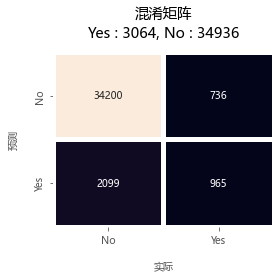

In [422]:
# 输出矩阵
plt.figure(figsize=(4,4))
plt.title('混淆矩阵\nYes : %i, No : %i'%(y_train.value_counts().tolist()[1]
                                                      ,y_train.value_counts().tolist()[0]), pad=15)
sns.heatmap(cm_train, annot=True, fmt="", linewidths=5, cbar=False)
plt.xticks([0.5, 1.5], ["No", "Yes"])
plt.xlabel('实际', fontsize=10, labelpad=15)
plt.yticks([0.5, 1.5], ["No", "Yes"])
plt.ylabel('预测', fontsize=10, labelpad=15)

plt.tight_layout()
plt.show()

In [423]:
# 选取部分数据,使数据平衡.
df_train_0 = df[df['订阅结果'] == 0].head(2000)
df_train_1 = df[df['订阅结果'] == 1].head(2000)
df_train = pd.concat([df_train_0,df_train_1],axis = 0)


df_trai = df_train.sample(frac=1).reset_index(drop=True)
print(df_train.columns)

x = df_trai.drop(columns='订阅结果')
y = df_trai[['订阅结果']]

for i in x.columns:

    if x[i].dtype == 'object':
        x.loc[:, i] = LE.fit_transform(x[i])
    else:
        x.loc[:, i] = scaler.fit_transform(x[i].values.reshape(-1, 1))


x_train, x_test = x[:3200],x[3200:]
y_train, y_test = y[:3200],y[3200:]

Index(['年龄', '职业', '婚姻状况', '受教育程度', '信用是否违约', '是否有房屋贷款', '是否有个人贷款', '联系方式',
       '最后通话的月份', '最后通话是星期几', '最后通话时长', '本次营销期间接触客户的次数', '客户上次营销后经过的天数',
       '客户在本次营销前与银行接触的次数', '上次营销的结果', '就业变化率（季度指标）', '消费者物价指数（月度指标）',
       '消费者信心指数（月度指标）', '欧元区3个月利率（日度指标）', '就业人数（季度指标）', '订阅结果', '年龄分组',
       '通话时长分组'],
      dtype='object')


In [424]:
for model, model_name, model_param_grid in zip(classifiers, classifier_names, classifier_param_grid):
    #采用 StandardScaler 方法对数据规范化：均值为0，方差为1的正态分布
    pipeline = Pipeline([
            (model_name, model)
    ])
    model = GridSearchCV_work(pipeline, x_train, y_train, x_test, y_test, model_param_grid , score = 'accuracy')

GridSearch 最优参数： {'svc__C': 0.1, 'svc__gamma': 0.01}
GridSearch 最优分数： 0.9381
 准确率 0.9437
GridSearch 最优参数： {'decisiontreeclassifier__max_depth': 9}
GridSearch 最优分数： 0.9687
 准确率 0.9712
GridSearch 最优参数： {'randomforestclassifier__n_estimators': 6}
GridSearch 最优分数： 0.9688
 准确率 0.9700
GridSearch 最优参数： {'kneighborsclassifier__n_neighbors': 4}
GridSearch 最优分数： 0.9375
 准确率 0.9450
GridSearch 最优参数： {'adaboostclassifier__n_estimators': 70}
GridSearch 最优分数： 0.9687
 准确率 0.9725


In [425]:
model =  AdaBoostClassifier(random_state = 1,n_estimators=70)
model.fit(x_train,y_train)

AdaBoostClassifier(n_estimators=70, random_state=1)

In [426]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

cr_train = classification_report(y_train, train_pred)
cr_test = classification_report(y_test, test_pred)

cm_train = confusion_matrix(y_train, train_pred)
cm_test = confusion_matrix(y_test, test_pred)

In [427]:
print('1. 训练分类报告 : \n')
print(cr_train)
print('\n\n2. 测试分类报告 : \n')
print(cr_test)

1. 训练分类报告 : 

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1614
           1       0.99      0.98      0.98      1586

    accuracy                           0.98      3200
   macro avg       0.99      0.98      0.98      3200
weighted avg       0.99      0.98      0.98      3200



2. 测试分类报告 : 

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       386
           1       0.99      0.96      0.97       414

    accuracy                           0.97       800
   macro avg       0.97      0.97      0.97       800
weighted avg       0.97      0.97      0.97       800



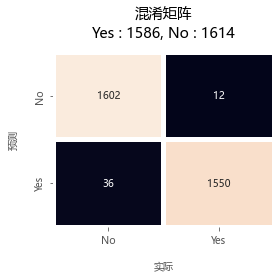

In [428]:
# 输出矩阵
plt.figure(figsize=(4,4))
plt.title('混淆矩阵\nYes : %i, No : %i'%(y_train.value_counts().tolist()[1]
                                                      ,y_train.value_counts().tolist()[0]), pad=15)
sns.heatmap(cm_train, annot=True, fmt="", linewidths=5, cbar=False)
plt.xticks([0.5, 1.5], ["No", "Yes"])
plt.xlabel('实际', fontsize=10, labelpad=15)
plt.yticks([0.5, 1.5], ["No", "Yes"])
plt.ylabel('预测', fontsize=10, labelpad=15)

plt.tight_layout()
plt.show()